# Assignment 1: Visualizing the Wine Dataset
by:
- Sam Yao
- Michael Amberg
- Rebecca Kuhlman

# NOTE: DO NOT PUSH .ipynb_checkpoints/ TO THE GITHUB

### Data Sources
- [1] http://www3.dsi.uminho.pt/pcortez/wine5.pdf
- [2] https://archive.ics.uci.edu/ml/datasets/Wine+Quality

## Business Understanding

- Describe the purpose of the data set you selected (i.e., why and how was this data collected in the first place?). 
- What is the prediction task for your data and why are other third parties interested in the result? 
- Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to these third parties?
- Be specific and use your own words to describe the aspects of the data.

### In your own words, give an overview of the dataset.
This dataset describes several physical and chemical qualities of various wines (both white and red) from Portugal [1]. These characteristics, such as pH, citric acid, alcohol content, and residual sugar, were tested by physicochemical machines by the CVRVV, the official wine testing entity of the region of Portugal which these wines were made. The output was determined by a minimum of three human judges, who judged the wine quality on a scale of 0-10 (0 being bad and 10 being excellent). 

### What is the prediction task for your data and why are other third parties interested in the result? 
We are to predict the rating of a wine, given its qualities, on a scale of one to ten. Third-party entities, such as winemakers and related businesses, are interested in these results so that they can determine what chemically constitutes a wine that will rank high. Then, wine can be manufactured that focuses on this attribute (or less on this attribute if there is a strong negative correlation between the rankin and a certain attribute). This high ranking can be used to market those wines, bringing in profits for the company.

### Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to these third parties?
Wine is often viewed as a very subjective experience. Wine chemical composition varies from year to year depending on the overall climate of the growing season. Given that quality is extremely subjective and variable, there is not a strong need for an extremely precise algorithm. With these considerations, a 60-70% accuracy will be deemed acceptable.

### Be specific and use your own words to describe the aspects of the data.

## Data Understanding

In [145]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.simplefilter('ignore', DeprecationWarning)

df_white_raw = pd.read_csv("winequality-white.csv")
df_red_raw = pd.read_csv("winequality-red.csv")

#Data csv format used ";" instead of ",", leading to us needing to manipulate file to use data
print(df_white_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None


In [32]:
print(df_red_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [3]:
df_red_raw.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [4]:
df_white_raw.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

There is no missing data points in this dataset. The majority is numerical data. Whether a wine has sulfates or not could be made into categorical data, and whether the wine is red or white is categorical.
The numerical day can be broken down into groups, such as not acidic wine, light acidity, medium acidity, etc.
Red wine acidity ranges from 4ph to 3.3ph at the very lowest
White wine acidity ranges from 3.6 to 2.8ph, with the sweetest white wines being the most acidic.

In [33]:
df_groupedRed = df_red_raw.groupby(['quality'])
df_groupedRed.count()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,10,10,10,10,10,10,10,10,10,10,10
4,53,53,53,53,53,53,53,53,53,53,53
5,681,681,681,681,681,681,681,681,681,681,681
6,638,638,638,638,638,638,638,638,638,638,638
7,199,199,199,199,199,199,199,199,199,199,199
8,18,18,18,18,18,18,18,18,18,18,18


In [34]:
df_red_raw['pH_range'] = pd.cut(df_red_raw['pH'],
                                 [0,3.075,3.3,3.7,3.9,4.5],
                                 labels=['Very High','High','Standard','Low','Very Low'])
                                #labels=['0','1','2','3','4'])
df_groupedRed.pH_range.describe()
plt.style.use('ggplot')

#plt.subplot(1,3,1)
#df_groupedRed.pH_range.plot.hist(5)
#plt.subplot(1,3,2)
#df_groupedRed.pH_range.plot.kde(0.2)

#plt.subplot(1,3,3)
#df_groupedRed.pH_range.plot.hist(50)
#df_groupedRed.pH_range.plot.kde(0.05, True)

# remember that visualization is interpretted, it supports evidence.
# plt.ylim([0, 0.06])

#plt.show()
#df_groupedRed.pH_range.plot.hist()

In [35]:
df_red_raw['ABV_range'] = pd.cut(df_red_raw['alcohol'],
                                 [0,12.5,13.5,14.5,100],
                                labels=['0','1','2','3'])
df_groupedRed.ABV_range.describe()

,count,unique,top,freq
quality,,,,
3,10,1,0,10
4,53,2,0,52
5,681,3,0,672
6,638,3,0,609
7,199,3,0,176
8,18,3,0,10


Initially there doesn't seem to be a correlation between ABV and quality. Popular Portugense wines often have a very low ABV, which may affect the algorithm.

In [82]:
dfRed = df_red_raw.copy()
dfRed['type'] = 'red'
dfRed['type#'] = 1
dfWhite = df_white_raw.copy()
dfWhite['type'] = 'white'
dfWhite['type#'] = 0

# The resulting dataset has 0 represent White Wine and 1 represent
df_merged = pd.concat([dfWhite,dfRed], axis = 0, ignore_index=True,)
df_merged

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,type#
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,white,0
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,white,0
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,white,0
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,white,0
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,white,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,red,1
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,red,1
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,red,1
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,red,1


## Data Visualization

<AxesSubplot: title={'center': 'total sulfur dioxide'}, xlabel='[type#, quality]'>

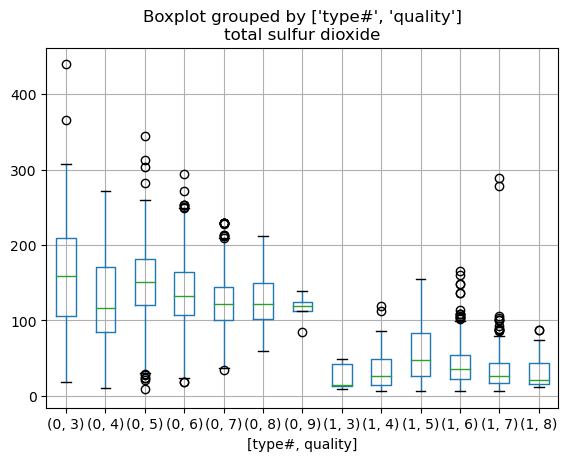

In [83]:
%matplotlib inline
df_merged.boxplot(column = ['total sulfur dioxide'], by=['type#','quality'])
# 0 represents white wine, 1 represents red wines

array([<AxesSubplot: title={'center': 'red'}>,
       <AxesSubplot: title={'center': 'white'}>], dtype=object)

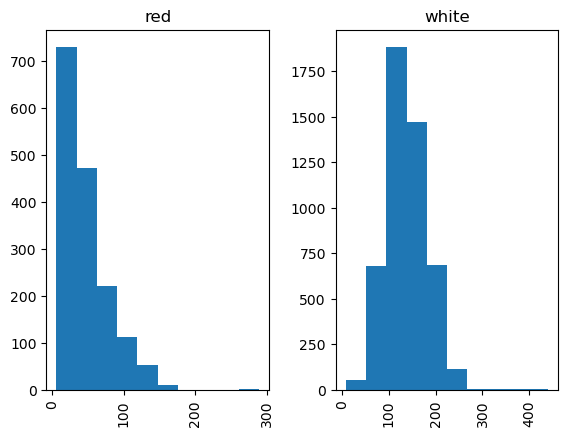

In [118]:
df_merged.hist(column=['total sulfur dioxide'], by=['type'])

<AxesSubplot: title={'center': 'pH'}, xlabel='[type#, quality]'>

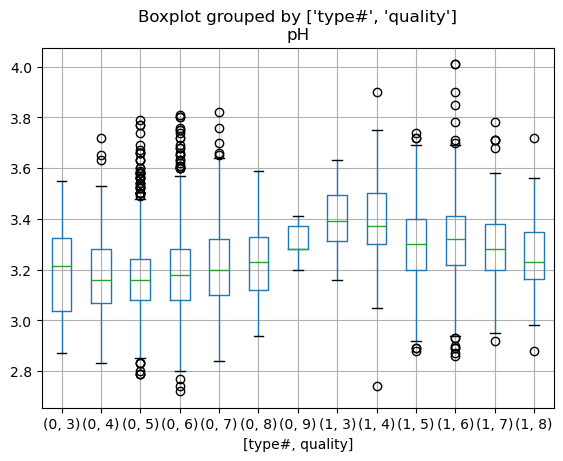

In [115]:
df_merged.boxplot(column = ['pH'], by=['type#','quality'])

<AxesSubplot: title={'center': 'alcohol'}, xlabel='[type#, quality]'>

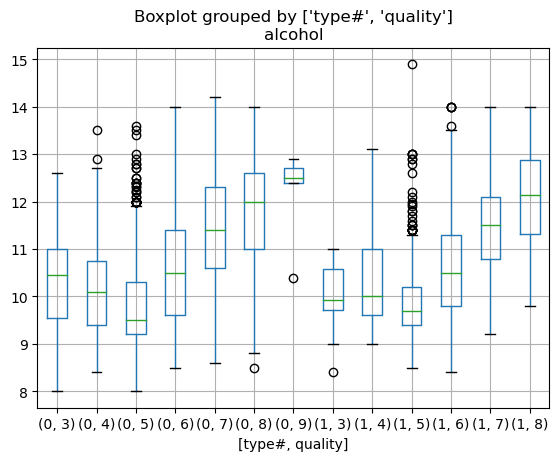

In [135]:
df_merged.boxplot(column = ['alcohol'], by=['type#','quality'])

type#
0    AxesSubplot(0.125,0.11;0.62x0.77)
1    AxesSubplot(0.125,0.11;0.62x0.77)
dtype: object

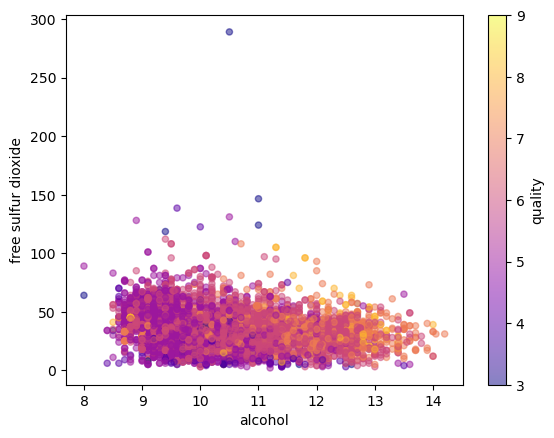

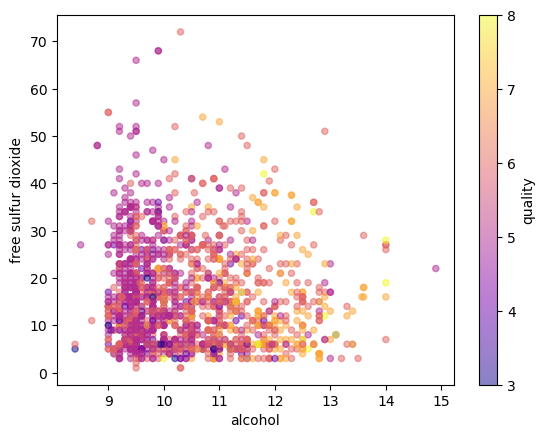

In [153]:
df_merged.groupby('type#').plot.scatter(x='alcohol', y='sulphates', c='quality', colormap='plasma', alpha = .5)

type#
0    AxesSubplot(0.125,0.11;0.62x0.77)
1    AxesSubplot(0.125,0.11;0.62x0.77)
dtype: object

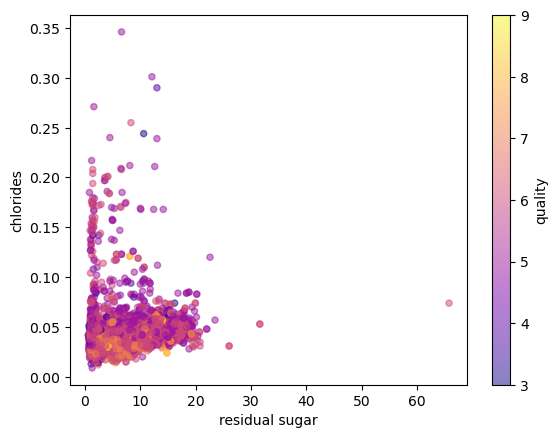

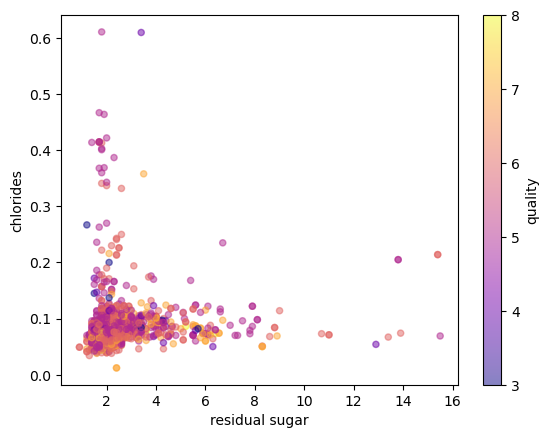

In [158]:
df_merged.groupby('type#').plot.scatter(x='residual sugar', y='chlorides', c='quality', colormap='plasma', alpha = .5)

## Extra Work 😡

In [143]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import umap

cats = df_merged[['type#','quality']]
df_merged_nums = df_merged.drop(columns=['type','type#','quality'], axis =0)

scaler = StandardScaler()
scaler.fit(df_merged_nums)
df_scaled = pd.DataFrame(scaler.transform(df_merged_nums), columns=list(df_merged_nums.columns))

df_merged_scaled = pd.concat([df_scaled,cats['type#']],axis = 1)


cats = cats.drop('type#',axis=1) #drop to use cats as target variable
le = LabelEncoder()
cats = le.fit_transform(cats)

# This is being done incorrectly, the train/test should be scaled seperated to prevent data leakage.
# idc tho because I'm not trying to make a model
X_train, X_test, y_train, y_test = train_test_split(df_merged_scaled, cats, test_size = 0.2)

X_train.head(3)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type#
4954,2.302410,0.487985,1.729905,-0.429482,0.398680,-1.494550,-1.871006,0.801538,-1.110254,0.663545,-0.747766,1
3309,-0.397511,0.730964,-0.334694,-0.051127,-0.486252,0.252123,-0.349353,-1.136135,-0.363868,-0.613385,1.600006,0
3098,-1.631761,-0.058716,-0.334694,0.264168,-0.971538,0.759221,0.234537,-0.829309,0.880108,-0.949419,0.426120,0


In [144]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(df_merged_scaled)
embedding.shape

(6497, 2)

Text(0.5, 1.0, 'UMAP projection of the Portuguese wine dataset')

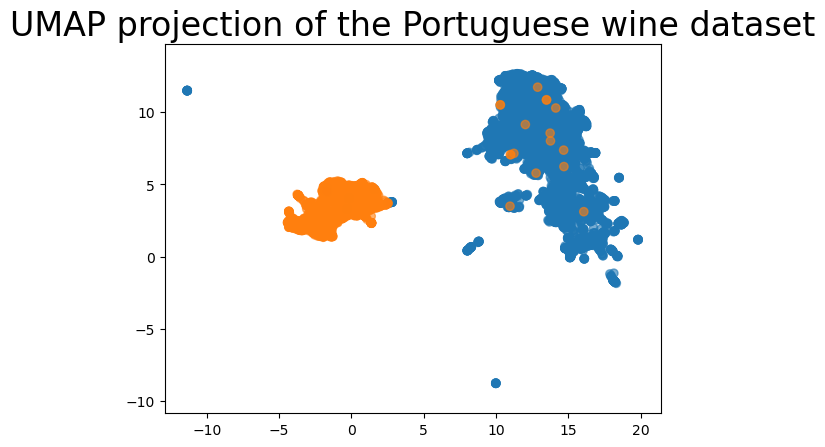

In [150]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in df_merged['type#']],
    alpha=.6)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Portuguese wine dataset', fontsize=24)

In [112]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=5, max_depth=19, learning_rate=.7)
model.fit(X_train,y_train)
preds = model.predict(X_test)
print(accuracy_score(y_test, preds)) # awful accuracy but no cleaning has been done tbf

0.6623076923076923


In [113]:
import shap
# do not run this if you want to avoid waiting a minute or two
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

Permutation explainer: 1301it [00:45, 22.10it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


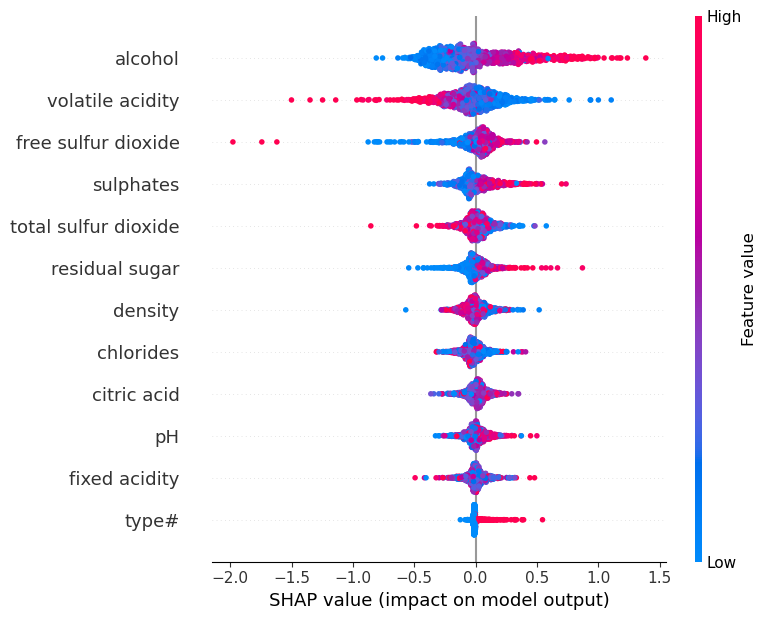

In [114]:
shap.summary_plot(shap_values)

array([2, 1, 3, ..., 2, 2, 1])